# Functions that will work on the background

## Image Segmentation

### Get bounding boxes from image from user interaction

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

In [19]:
rect_start = None
rect_end = None
drawing = False

In [20]:
def draw_rectangle(event, x, y, flags, param):
    """Mouse callback function to draw a rectangle."""
    global rect_start, rect_end, drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        rect_start = (x, y)
        drawing = True

    elif event == cv2.EVENT_LBUTTONUP:
        rect_end = (x, y)
        drawing = False
        cv2.rectangle(img_display, rect_start, rect_end, (255, 0, 0), 4)
        cv2.imshow("Draw Rectangle", img_display)

In [21]:
def interactive_bbox_selection(image_path, window_width=800, window_height=800):
    """Allows the user to draw a rectangle and converts to Ultralytics BBox format."""
    global img_display
    
    # Load image
    img = cv2.imread(image_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = img.copy()

    cv2.namedWindow("Draw Rectangle", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Draw Rectangle", window_width, window_height)  # Resize window

    # Set mouse callback
    cv2.setMouseCallback("Draw Rectangle", draw_rectangle)

    while True:
        cv2.imshow("Draw Rectangle", img_display)
        key = cv2.waitKey(1) & 0xFF
        if key == 13:  # Press 'Enter' to finish
            break

    cv2.destroyAllWindows()

    # Convert to Ultralytics BBox format (normalized)
    if rect_start and rect_end:
        x1, y1 = rect_start
        x2, y2 = rect_end

        # Ensure coordinates are sorted properly
        x_min, y_min = min(x1, x2), min(y1, y2)
        x_max, y_max = max(x1, x2), max(y1, y2)

        # Convert to Ultralytics normalized BBox format
        coord = [
            x_min,
            y_min,
            x_max,
            y_max
        ]
        
        print("Coordinates:", coord)
        return coord
    else:
        print("No rectangle was drawn.")
        return None

In [6]:
coord = interactive_bbox_selection("test_image.jpg")

Coordinates: [142, 133, 3445, 5973]


### Segment image based on rectangle coordinates


image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\test_image.jpg: 640x640 1 0, 4251.6ms
Speed: 7.5ms preprocess, 4251.6ms inference, 80.9ms postprocess per image at shape (1, 3, 640, 640)


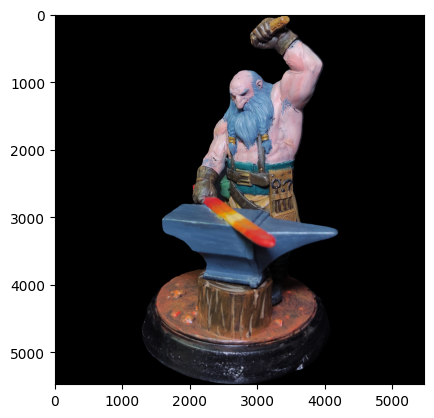

In [9]:
from ultralytics import SAM
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

source = "test_image.jpg"

model = SAM("sam_l.pt")

results = model(source,
                device="cpu",
                retina_masks=True,
                imgsz=640,
                conf=0.2,
                iou=0.4,
                bboxes=[206, 259, 3293, 5996])

for result in results:
    img = np.copy(result.orig_img)

    for ci, c in enumerate(result):
        b_mask = np.zeros(img.shape[:2], np.uint8)

        # Create contour mask 
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

        isolated = img.copy()
        isolated[b_mask == 0] = 0

        contour = contour.reshape(-1, 2)

        x_min, y_min = np.min(contour, axis=0)
        x_max, y_max = np.max(contour, axis=0)

        # Crop the image to get only the segmented
        cropped_image = isolated[y_min:y_max, x_min:x_max]
        resultado_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

        # Make the image square and centralize the segmented image
        height, width, _ = resultado_rgb.shape
        size = max(height, width)
        square_image = np.zeros((size, size, 3), dtype=np.uint8)

        # Calculate the top-left corner to centralize the image
        y_offset = (size - height) // 2
        x_offset = (size - width) // 2

        square_image[y_offset:y_offset + height, x_offset:x_offset + width] = resultado_rgb

        plt.imshow(square_image)

Making it a function

In [26]:
def segmenting_image(coordinates, model, source):
    results = model(source,
                    device="cuda",
                    retina_masks=True,
                    imgsz=640,
                    bboxes=coordinates)
    for result in results:
        img = np.copy(result.orig_img)
        for ci, c in enumerate(result):
            b_mask = np.zeros(img.shape[:2], np.uint8)
            # Create contour mask 
            contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
            cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)
            
            # Create an RGBA image with an alpha channel
            isolated = np.zeros((*img.shape[:2], 4), dtype=np.uint8)
            isolated[..., :3] = img
            isolated[b_mask == 0, 3] = 0  # Set alpha to 0 for background
            isolated[b_mask != 0, 3] = 255  # Set alpha to 255 for the segmented object
            
            contour = contour.reshape(-1, 2)
            x_min, y_min = np.min(contour, axis=0)
            x_max, y_max = np.max(contour, axis=0)
            
            # Crop the image to get only the segmented object
            cropped_image = isolated[y_min:y_max, x_min:x_max]
            
            # Create a square image with 4 channels (RGBA)
            height, width, _ = cropped_image.shape
            size = max(height, width)
            square_image = np.zeros((size, size, 4), dtype=np.uint8)
            
            # Calculate the top-left corner to centralize the image
            y_offset = (size - height) // 2
            x_offset = (size - width) // 2
            
            # Copy the cropped image into the square image
            square_image[y_offset:y_offset + height, x_offset:x_offset + width] = cropped_image
            
            # Save the image with 4 channels (RGBA)
            cv2.imwrite("segmented.png", square_image)
            
            # For display, convert to RGB for matplotlib
            plt.imshow(cv2.cvtColor(square_image, cv2.COLOR_RGBA2BGRA))
            plt.axis('off')
            plt.show()

### Combining everything

Coordinates: [159, 110, 941, 1644]

image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0073.jpg: 640x640 1 0, 6511.0ms
Speed: 3.5ms preprocess, 6511.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


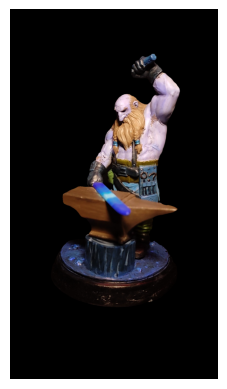

In [ ]:
from ultralytics import SAM
%matplotlib inline

rect_start = None
rect_end = None
drawing = False

source = "frames/frame_0073.jpg"
model = SAM("models/sam_l.pt")

coordinates = interactive_bbox_selection(source)
segmenting_image(coordinates, model, source)

## 3D reconstruction from videos

### Extract segmented frames from Video

In [1]:
import torch
import numpy as np

# Segment in every frame
def segmenting_image(coordinates, model, source):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = model(source,
                    device=device,
                    retina_masks=True,
                    imgsz=640,
                    bboxes=coordinates)
    
    for result in results:
        img = np.copy(result.orig_img)
        for ci, c in enumerate(result):
            b_mask = np.zeros(img.shape[:2], np.uint8)

            # Create contour mask 
            contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
            cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

            res = cv2.bitwise_and(img, img, mask=b_mask)
            
            contour = contour.reshape(-1, 2)
            x_min, y_min = np.min(contour, axis=0)
            x_max, y_max = np.max(contour, axis=0)
            
            # Crop the image to get only the segmented object
            cropped_image = res[y_min:y_max, x_min:x_max]

            return cropped_image

In [ ]:
import cv2
import os

def extract_frames(video_path, output_folder, frame_interval=10, coordinates = None, model = None):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    extracted_count = 0
    
    # Get rotation information
    rotation = int(cap.get(cv2.CAP_PROP_ORIENTATION_META))
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Apply rotation correction based on metadata
        if rotation == 90:
            frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        elif rotation == 180:
            frame = cv2.rotate(frame, cv2.ROTATE_180)
        elif rotation == 270:
            frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
        
        # Save frame
        if frame_count % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f"frame_{extracted_count:04d}.png")

            #cv2.imwrite(frame_filename, frame)
            #frame = segmenting_image(coordinates, model, frame_filename)

            cv2.imwrite(frame_filename, frame)

            print(f"Extracted {extracted_count} image(s)")
            
            extracted_count += 1
        
        frame_count += 1 
    print(f"---- Image Extraction succeeded ----")
    cap.release()

In [3]:
from ultralytics import SAM

#model = SAM("models/sam_l.pt")
#coordinates = [159, 110, 941, 1644]

extract_frames("test_video.mp4", "frames", 10)

Extracted 0 image(s)
Extracted 1 image(s)
Extracted 2 image(s)
Extracted 3 image(s)
Extracted 4 image(s)
Extracted 5 image(s)
Extracted 6 image(s)
Extracted 7 image(s)
Extracted 8 image(s)
Extracted 9 image(s)
Extracted 10 image(s)
Extracted 11 image(s)
Extracted 12 image(s)
Extracted 13 image(s)
Extracted 14 image(s)
Extracted 15 image(s)
Extracted 16 image(s)
Extracted 17 image(s)
Extracted 18 image(s)
Extracted 19 image(s)
Extracted 20 image(s)
Extracted 21 image(s)
Extracted 22 image(s)
Extracted 23 image(s)
Extracted 24 image(s)
Extracted 25 image(s)
Extracted 26 image(s)
Extracted 27 image(s)
Extracted 28 image(s)
Extracted 29 image(s)
Extracted 30 image(s)
Extracted 31 image(s)
Extracted 32 image(s)
Extracted 33 image(s)
Extracted 34 image(s)
Extracted 35 image(s)
Extracted 36 image(s)
Extracted 37 image(s)
Extracted 38 image(s)
Extracted 39 image(s)
Extracted 40 image(s)
Extracted 41 image(s)
Extracted 42 image(s)
Extracted 43 image(s)
Extracted 44 image(s)
Extracted 45 image(s

### Create Depth Images

In [ ]:
import torch
from transformers import DepthProImageProcessorFast, DepthProForDepthEstimation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_processor = DepthProImageProcessorFast.from_pretrained("apple/DepthPro-hf")
model = DepthProForDepthEstimation.from_pretrained("apple/DepthPro-hf").to(device)

In [ ]:
from PIL import Image

image = Image.open("frames/frame_0094.jpg")
inputs = image_processor(images=image, return_tensors="pt").to("cpu")

with torch.no_grad():
    outputs = model(**inputs)

post_processed_output = image_processor.post_process_depth_estimation(
    outputs, target_sizes=[(image.height, image.width)],
)

depth = post_processed_output[0]["predicted_depth"]
depth = (depth - depth.min()) / (depth.max() - depth.min())
depth = depth * 255.
depth = depth.detach().cpu().numpy()
depth = Image.fromarray(depth.astype("uint8"))
depth.save("depth_images/frame_0094.jpg")

In [ ]:
from PIL import Image
import os

frame_path = "frames"
depth_path = "depth_images"

os.makedirs(depth_path, exist_ok=True)

for frame in os.listdir("frames"):

    image = Image.open(os.path.join(frame_path, frame))
    inputs = image_processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    post_processed_output = image_processor.post_process_depth_estimation(
        outputs, target_sizes=[(image.height, image.width)],
    )

    depth = post_processed_output[0]["predicted_depth"]
    depth = (depth - depth.min()) / (depth.max() - depth.min())
    depth = depth * 255.
    depth = depth.detach().cpu().numpy()
    depth = Image.fromarray(depth.astype("uint8"))
    depth.save(os.path.join(depth_path, frame))
    print(f"Image {frame} processed")

print("------ All images converted to depth images ------")

### Sparse reconstruction using Structure-from-Motion (SfM) and Multi-View Stereo (MVS)

In [7]:
import os
import numpy as np
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

class SfMMVSReconstructor:
    """
    A class for performing 3D reconstruction from 360° video frames using
    Structure-from-Motion (SfM) and Multi-View Stereo (MVS) techniques.
    """
    
    def __init__(self, frames_dir, output_dir, min_matches=20, 
                 feature_method="sift", matching_ratio=0.7):
        """
        Initialize the reconstructor.
        
        Args:
            frames_dir: Directory containing the input frames
            output_dir: Directory to save reconstruction results
            min_matches: Minimum number of feature matches between frames
            feature_method: Feature extraction method ('sift', 'orb', 'akaze')
            matching_ratio: Ratio test threshold for feature matching
        """
        self.frames_dir = Path(frames_dir)
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True, parents=True)
        
        self.min_matches = min_matches
        self.matching_ratio = matching_ratio
        self.feature_method = feature_method
        
        # Initialize feature detector
        if feature_method == "sift":
            self.detector = cv2.SIFT_create()
        elif feature_method == "orb":
            self.detector = cv2.ORB_create(nfeatures=10000)
        elif feature_method == "akaze":
            self.detector = cv2.AKAZE_create()
        else:
            raise ValueError(f"Unsupported feature method: {feature_method}")
        
        # Camera parameters (to be estimated or provided)
        self.K = None
        self.dist_coeffs = None
        
        # Data structures for reconstruction
        self.frames = []
        self.keypoints = []
        self.descriptors = []
        self.matches = {}
        self.camera_matrices = []
        self.point_cloud = None
        
    def load_frames(self, max_frames=None):
        """Load video frames from the input directory."""
        frame_paths = sorted(list(self.frames_dir.glob("*.jpg")) + 
                            list(self.frames_dir.glob("*.png")))
        
        if max_frames:
            frame_paths = frame_paths[:max_frames]
            
        print(f"Loading {len(frame_paths)} frames...")
        self.frames = [cv2.imread(str(path)) for path in tqdm(frame_paths)]
        
        if not self.frames:
            raise ValueError(f"No frames found in {self.frames_dir}")
            
        print(f"Loaded {len(self.frames)} frames")
        
    def estimate_camera_intrinsics(self, image_width=None, image_height=None):
        """
        Estimate camera intrinsic parameters if not provided.
        For 360 cameras, this is an approximation.
        """
        if not self.frames:
            raise ValueError("No frames loaded. Call load_frames() first.")
            
        if image_width is None or image_height is None:
            image_height, image_width = self.frames[0].shape[:2]
            
        # Approximate focal length (a common approximation)
        focal_length = max(image_width, image_height)
        
        # Principal point at the image center
        cx = image_width / 2
        cy = image_height / 2
        
        # Camera intrinsic matrix
        self.K = np.array([
            [focal_length, 0, cx],
            [0, focal_length, cy],
            [0, 0, 1]
        ], dtype=np.float32)
        
        # For 360 cameras, distortion is complex. This is a simple approximation.
        self.dist_coeffs = np.zeros(5, dtype=np.float32)
        
        print("Camera intrinsics estimated")
        return self.K, self.dist_coeffs
        
    def extract_features(self):
        """Extract features from all frames."""
        if not self.frames:
            raise ValueError("No frames loaded. Call load_frames() first.")
            
        print("Extracting features from frames...")
        for i, frame in enumerate(tqdm(self.frames)):
            # Convert to grayscale for feature detection
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Detect keypoints and compute descriptors
            kps, desc = self.detector.detectAndCompute(gray, None)
            
            self.keypoints.append(kps)
            self.descriptors.append(desc)
            
            print(f"Frame {i}: {len(kps)} keypoints detected")
            
        return self.keypoints, self.descriptors
        
    def match_features(self):
        """Match features between consecutive frames and selected frame pairs."""
        if not self.descriptors:
            raise ValueError("No features extracted. Call extract_features() first.")
            
        # Create FLANN matcher
        if self.feature_method == "sift":
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
            search_params = dict(checks=50)
            matcher = cv2.FlannBasedMatcher(index_params, search_params)
        else:
            # For binary descriptors (ORB, AKAZE)
            matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
            
        print("Matching features between frames...")
        for i in tqdm(range(len(self.frames) - 1)):
            # Match consecutive frames
            self._match_frame_pair(matcher, i, i+1)
            
            # For 360 camera setup, match with frames further away
            # These connections help create a more robust reconstruction
            step = max(5, len(self.frames) // 10)  # Match every 10% of frames
            for j in range(i+step, len(self.frames), step):
                if j < len(self.frames):
                    self._match_frame_pair(matcher, i, j)
        
        # For 360 videos, also match the last frame with the first one to close the loop
        if len(self.frames) > 2:
            self._match_frame_pair(matcher, 0, len(self.frames) - 1)
            
        print(f"Matched features across {len(self.matches)} frame pairs")
        return self.matches
        
    def _match_frame_pair(self, matcher, i, j):
        """Match features between two frames using ratio test."""
        if self.feature_method == "sift":
            # For SIFT descriptors
            matches = matcher.knnMatch(self.descriptors[i], self.descriptors[j], k=2)
            
            # Apply ratio test
            good_matches = []
            for m, n in matches:
                if m.distance < self.matching_ratio * n.distance:
                    good_matches.append(m)
        else:
            # For binary descriptors
            matches = matcher.match(self.descriptors[i], self.descriptors[j])
            
            # Sort by distance
            matches = sorted(matches, key=lambda x: x.distance)
            
            # Keep only the top matches
            max_matches = int(len(matches) * self.matching_ratio)
            good_matches = matches[:max_matches]
            
        if len(good_matches) >= self.min_matches:
            self.matches[(i, j)] = good_matches
            print(f"Matched frames {i}-{j}: {len(good_matches)} good matches")
        else:
            print(f"Insufficient matches between frames {i}-{j}: {len(good_matches)} < {self.min_matches}")
            
    def estimate_camera_poses(self):
        """Estimate camera poses from feature matches."""
        if not self.matches:
            raise ValueError("No feature matches. Call match_features() first.")
            
        if self.K is None:
            self.estimate_camera_intrinsics()
            
        # Initialize camera matrices
        self.camera_matrices = [None] * len(self.frames)
        
        # First camera is at the origin
        self.camera_matrices[0] = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
        
        points_3d = []
        points_colors = []
        point_track_ids = {}
        next_track_id = 0
        
        print("Estimating camera poses...")
        for (i, j), matches in tqdm(sorted(self.matches.items())):
            if self.camera_matrices[i] is None and self.camera_matrices[j] is None:
                # Skip if neither camera has been estimated yet
                continue
                
            # Extract matched keypoints
            kp1 = self.keypoints[i]
            kp2 = self.keypoints[j]
            
            pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
            pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
            
            # Calculate essential matrix
            E, mask = cv2.findEssentialMat(pts1, pts2, self.K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
            
            if E is None:
                print(f"Failed to find essential matrix for frames {i}-{j}")
                continue
                
            # Keep only inliers
            inliers_mask = mask.ravel() == 1
            if np.sum(inliers_mask) < self.min_matches:
                print(f"Not enough inliers for frames {i}-{j}")
                continue
                
            pts1 = pts1[inliers_mask]
            pts2 = pts2[inliers_mask]
            inlier_matches = [m for m, msk in zip(matches, inliers_mask) if msk]
            
            # Recover relative pose
            _, R, t, _ = cv2.recoverPose(E, pts1, pts2, self.K)
            
            # If first camera is not estimated yet
            if self.camera_matrices[i] is None:
                # If second camera is estimated, compute the first camera from it
                if self.camera_matrices[j] is not None:
                    Rj, tj = self.camera_matrices[j][:, :3], self.camera_matrices[j][:, 3]
                    Ri = Rj @ R.T
                    ti = Rj @ (-R.T @ t) + tj
                    self.camera_matrices[i] = np.hstack((Ri, ti.reshape(3, 1)))
            # If second camera is not estimated yet
            elif self.camera_matrices[j] is None:
                # Compute second camera from the first
                Ri, ti = self.camera_matrices[i][:, :3], self.camera_matrices[i][:, 3]
                Rj = Ri @ R
                tj = Ri @ t + ti
                self.camera_matrices[j] = np.hstack((Rj, tj.reshape(3, 1)))
            
            # Triangulate points
            if self.camera_matrices[i] is not None and self.camera_matrices[j] is not None:
                proj1 = self.K @ self.camera_matrices[i]
                proj2 = self.K @ self.camera_matrices[j]
                
                # Triangulate points
                points_4d = cv2.triangulatePoints(proj1, proj2, pts1.T, pts2.T)
                
                # Convert to 3D coordinates
                points_4d /= points_4d[3]
                new_points_3d = points_4d[:3].T
                
                # Get colors from first frame
                colors = np.array([self.frames[i][int(pt[1]), int(pt[0])] for pt in pts1])
                
                # Add points to the 3D point cloud
                for k, (point, color) in enumerate(zip(new_points_3d, colors)):
                    track_key = (i, inlier_matches[k].queryIdx)
                    
                    if track_key not in point_track_ids:
                        point_track_ids[track_key] = next_track_id
                        next_track_id += 1
                        points_3d.append(point)
                        points_colors.append(color[::-1])  # BGR to RGB
        
        self.point_cloud = {
            'points': np.array(points_3d),
            'colors': np.array(points_colors) / 255.0  # Normalize colors
        }
        
        num_estimated = sum(1 for cm in self.camera_matrices if cm is not None)
        print(f"Estimated {num_estimated}/{len(self.frames)} camera poses")
        print(f"Reconstructed {len(points_3d)} 3D points")
        
        return self.camera_matrices, self.point_cloud
        
    def visualize_reconstruction(self):
        """Visualize the sparse reconstruction."""
        if self.point_cloud is None:
            raise ValueError("No point cloud. Call estimate_camera_poses() first.")
            
        # Create Open3D point cloud
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(self.point_cloud['points'])
        pcd.colors = o3d.utility.Vector3dVector(self.point_cloud['colors'])
        
        # Create camera frames for visualization
        camera_frames = []
        for i, cam in enumerate(self.camera_matrices):
            if cam is not None:
                R = cam[:, :3]
                t = cam[:, 3]
                
                # Create a coordinate frame for the camera
                frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
                frame.rotate(R)
                frame.translate(t)
                camera_frames.append(frame)
        
        # Visualize
        o3d.visualization.draw_geometries([pcd] + camera_frames)
        
        # Save the point cloud
        o3d.io.write_point_cloud(str(self.output_dir / "sparse_reconstruction.ply"), pcd)
        print(f"Point cloud saved to {self.output_dir / 'sparse_reconstruction.ply'}")
        
    def dense_reconstruction(self):
        """Perform dense reconstruction using MVS."""
        if self.point_cloud is None:
            raise ValueError("No point cloud. Call estimate_camera_poses() first.")
            
        print("Starting dense reconstruction...")
        
        # For dense reconstruction, we'll use Open3D's implementation of PMVS
        volume = o3d.pipelines.integration.ScalableTSDFVolume(
            voxel_length=0.01,
            sdf_trunc=0.04,
            color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8
        )
        
        # For each frame with a valid camera pose, create an RGBD image and integrate
        for i, cam in enumerate(tqdm(self.camera_matrices)):
            if cam is None:
                continue
                
            # Create depth map from the point cloud (this is simplified)
            # In a real application, you would use a proper MVS algorithm
            # This is just for demonstration purposes
            depth = np.zeros((self.frames[i].shape[0], self.frames[i].shape[1]), dtype=np.float32)
            
            # Project 3D points to this view
            R = cam[:, :3]
            t = cam[:, 3]
            for point in self.point_cloud:
                proj_point = R @ point[:3] + t
                if proj_point[2] > 0:
                    u = int((proj_point[0] * self.K[0, 0] / proj_point[2]) + self.K[0, 2])
                    v = int((proj_point[1] * self.K[1, 1] / proj_point[2]) + self.K[1, 2])
                    if 0 <= u < depth.shape[1] and 0 <= v < depth.shape[0]:
                        depth[v, u] = proj_point[2]
            
            color = cv2.cvtColor(self.frames[i], cv2.COLOR_BGR2RGB)
            rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
                o3d.geometry.Image(color), o3d.geometry.Image(depth), convert_rgb_to_intensity=False
            )
            intrinsic = o3d.camera.PinholeCameraIntrinsic(
                width=depth.shape[1], height=depth.shape[0], fx=self.K[0, 0], fy=self.K[1, 1], cx=self.K[0, 2], cy=self.K[1, 2]
            )
            volume.integrate(rgbd, intrinsic, np.linalg.inv(cam))
        
        mesh = volume.extract_triangle_mesh()
        mesh.compute_vertex_normals()
        o3d.io.write_triangle_mesh(str(self.output_dir / "dense_reconstruction.ply"), mesh)
        print("Dense reconstruction completed and saved.")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
frames_dir = "frames"
output_dir = "output"

reconstructor = SfMMVSReconstructor(
    frames_dir=frames_dir,
    output_dir=output_dir,
    min_matches=20,  # Minimum matches between frames
    feature_method="sift",  # Feature extraction method ('sift', 'orb', 'akaze')
    matching_ratio=0.7  # Ratio test threshold for feature matching
)

# Run the reconstruction pipeline
reconstructor.load_frames(max_frames=100)  # Limit number of frames if needed
reconstructor.estimate_camera_intrinsics()  # Estimate camera parameters
reconstructor.extract_features()  # Extract features from frames
reconstructor.match_features()  # Match features between frames
reconstructor.estimate_camera_poses()  # Estimate camera poses and create sparse reconstruction
reconstructor.visualize_reconstruction()

Loading 95 frames...


100%|██████████| 95/95 [00:01<00:00, 51.80it/s]


Loaded 95 frames
Camera intrinsics estimated
Extracting features from frames...


  1%|          | 1/95 [00:00<00:37,  2.48it/s]

Frame 0: 3636 keypoints detected


  2%|▏         | 2/95 [00:00<00:34,  2.71it/s]

Frame 1: 3596 keypoints detected


  3%|▎         | 3/95 [00:01<00:33,  2.72it/s]

Frame 2: 3731 keypoints detected


  4%|▍         | 4/95 [00:01<00:35,  2.55it/s]

Frame 3: 3645 keypoints detected


  5%|▌         | 5/95 [00:01<00:33,  2.67it/s]

Frame 4: 3639 keypoints detected


  6%|▋         | 6/95 [00:02<00:32,  2.74it/s]

Frame 5: 3358 keypoints detected


  7%|▋         | 7/95 [00:02<00:32,  2.70it/s]

Frame 6: 3474 keypoints detected


  8%|▊         | 8/95 [00:02<00:31,  2.74it/s]

Frame 7: 3278 keypoints detected


  9%|▉         | 9/95 [00:03<00:32,  2.67it/s]

Frame 8: 3203 keypoints detected


 11%|█         | 10/95 [00:03<00:31,  2.73it/s]

Frame 9: 3101 keypoints detected


 12%|█▏        | 11/95 [00:04<00:31,  2.69it/s]

Frame 10: 3136 keypoints detected


 13%|█▎        | 12/95 [00:04<00:30,  2.68it/s]

Frame 11: 2988 keypoints detected


 14%|█▎        | 13/95 [00:04<00:31,  2.57it/s]

Frame 12: 3028 keypoints detected


 15%|█▍        | 14/95 [00:05<00:31,  2.59it/s]

Frame 13: 2808 keypoints detected


 16%|█▌        | 15/95 [00:05<00:30,  2.60it/s]

Frame 14: 2884 keypoints detected


 17%|█▋        | 16/95 [00:06<00:30,  2.55it/s]

Frame 15: 2777 keypoints detected


 18%|█▊        | 17/95 [00:06<00:30,  2.55it/s]

Frame 16: 2707 keypoints detected


 19%|█▉        | 18/95 [00:06<00:29,  2.64it/s]

Frame 17: 2677 keypoints detected


 20%|██        | 19/95 [00:07<00:28,  2.65it/s]

Frame 18: 2563 keypoints detected


 21%|██        | 20/95 [00:07<00:28,  2.65it/s]

Frame 19: 2399 keypoints detected


 22%|██▏       | 21/95 [00:07<00:28,  2.62it/s]

Frame 20: 2467 keypoints detected


 23%|██▎       | 22/95 [00:08<00:28,  2.58it/s]

Frame 21: 2428 keypoints detected


 24%|██▍       | 23/95 [00:08<00:28,  2.54it/s]

Frame 22: 2387 keypoints detected


 25%|██▌       | 24/95 [00:09<00:27,  2.60it/s]

Frame 23: 2414 keypoints detected


 26%|██▋       | 25/95 [00:09<00:26,  2.67it/s]

Frame 24: 2193 keypoints detected


 27%|██▋       | 26/95 [00:09<00:25,  2.65it/s]

Frame 25: 2205 keypoints detected


 28%|██▊       | 27/95 [00:10<00:25,  2.62it/s]

Frame 26: 2186 keypoints detected


 29%|██▉       | 28/95 [00:10<00:26,  2.53it/s]

Frame 27: 2029 keypoints detected


 31%|███       | 29/95 [00:11<00:26,  2.53it/s]

Frame 28: 2049 keypoints detected


 32%|███▏      | 30/95 [00:11<00:25,  2.50it/s]

Frame 29: 2103 keypoints detected


 33%|███▎      | 31/95 [00:11<00:24,  2.63it/s]

Frame 30: 1742 keypoints detected


 34%|███▎      | 32/95 [00:12<00:24,  2.58it/s]

Frame 31: 1738 keypoints detected


 35%|███▍      | 33/95 [00:12<00:25,  2.47it/s]

Frame 32: 2002 keypoints detected


 36%|███▌      | 34/95 [00:13<00:23,  2.59it/s]

Frame 33: 1921 keypoints detected


 37%|███▋      | 35/95 [00:13<00:22,  2.71it/s]

Frame 34: 1889 keypoints detected


 38%|███▊      | 36/95 [00:13<00:22,  2.63it/s]

Frame 35: 1654 keypoints detected


 39%|███▉      | 37/95 [00:14<00:23,  2.50it/s]

Frame 36: 1510 keypoints detected


 40%|████      | 38/95 [00:14<00:22,  2.57it/s]

Frame 37: 1477 keypoints detected


 41%|████      | 39/95 [00:14<00:21,  2.55it/s]

Frame 38: 1683 keypoints detected


 42%|████▏     | 40/95 [00:15<00:21,  2.54it/s]

Frame 39: 1523 keypoints detected


 43%|████▎     | 41/95 [00:15<00:21,  2.47it/s]

Frame 40: 1474 keypoints detected


 44%|████▍     | 42/95 [00:16<00:21,  2.47it/s]

Frame 41: 1466 keypoints detected


 45%|████▌     | 43/95 [00:16<00:21,  2.37it/s]

Frame 42: 1482 keypoints detected


 46%|████▋     | 44/95 [00:17<00:21,  2.39it/s]

Frame 43: 1486 keypoints detected


 47%|████▋     | 45/95 [00:17<00:20,  2.42it/s]

Frame 44: 1637 keypoints detected


 48%|████▊     | 46/95 [00:17<00:19,  2.57it/s]

Frame 45: 1632 keypoints detected


 49%|████▉     | 47/95 [00:18<00:18,  2.63it/s]

Frame 46: 1678 keypoints detected


 51%|█████     | 48/95 [00:18<00:18,  2.59it/s]

Frame 47: 1625 keypoints detected


 52%|█████▏    | 49/95 [00:18<00:17,  2.59it/s]

Frame 48: 1677 keypoints detected


 53%|█████▎    | 50/95 [00:19<00:17,  2.61it/s]

Frame 49: 1856 keypoints detected


 54%|█████▎    | 51/95 [00:19<00:17,  2.57it/s]

Frame 50: 1662 keypoints detected


 55%|█████▍    | 52/95 [00:20<00:16,  2.69it/s]

Frame 51: 1734 keypoints detected


 56%|█████▌    | 53/95 [00:20<00:16,  2.58it/s]

Frame 52: 1838 keypoints detected


 57%|█████▋    | 54/95 [00:20<00:16,  2.46it/s]

Frame 53: 1923 keypoints detected


 58%|█████▊    | 55/95 [00:21<00:16,  2.44it/s]

Frame 54: 1904 keypoints detected


 59%|█████▉    | 56/95 [00:21<00:14,  2.60it/s]

Frame 55: 1857 keypoints detected


 60%|██████    | 57/95 [00:22<00:15,  2.49it/s]

Frame 56: 2097 keypoints detected


 61%|██████    | 58/95 [00:22<00:14,  2.55it/s]

Frame 57: 1839 keypoints detected


 62%|██████▏   | 59/95 [00:22<00:13,  2.60it/s]

Frame 58: 1879 keypoints detected


 63%|██████▎   | 60/95 [00:23<00:14,  2.50it/s]

Frame 59: 1969 keypoints detected


 64%|██████▍   | 61/95 [00:23<00:14,  2.40it/s]

Frame 60: 1997 keypoints detected


 65%|██████▌   | 62/95 [00:24<00:13,  2.48it/s]

Frame 61: 1949 keypoints detected


 66%|██████▋   | 63/95 [00:24<00:12,  2.61it/s]

Frame 62: 2068 keypoints detected


 67%|██████▋   | 64/95 [00:24<00:11,  2.62it/s]

Frame 63: 2087 keypoints detected


 68%|██████▊   | 65/95 [00:25<00:11,  2.64it/s]

Frame 64: 2152 keypoints detected


 69%|██████▉   | 66/95 [00:25<00:10,  2.67it/s]

Frame 65: 2260 keypoints detected


 71%|███████   | 67/95 [00:25<00:10,  2.70it/s]

Frame 66: 2335 keypoints detected


 72%|███████▏  | 68/95 [00:26<00:10,  2.65it/s]

Frame 67: 2397 keypoints detected


 73%|███████▎  | 69/95 [00:26<00:09,  2.63it/s]

Frame 68: 2630 keypoints detected


 74%|███████▎  | 70/95 [00:27<00:09,  2.54it/s]

Frame 69: 2580 keypoints detected


 75%|███████▍  | 71/95 [00:27<00:09,  2.55it/s]

Frame 70: 2614 keypoints detected


 76%|███████▌  | 72/95 [00:27<00:08,  2.64it/s]

Frame 71: 2650 keypoints detected


 77%|███████▋  | 73/95 [00:28<00:08,  2.56it/s]

Frame 72: 2899 keypoints detected


 78%|███████▊  | 74/95 [00:28<00:08,  2.46it/s]

Frame 73: 2899 keypoints detected


 79%|███████▉  | 75/95 [00:29<00:08,  2.48it/s]

Frame 74: 3016 keypoints detected


 80%|████████  | 76/95 [00:29<00:07,  2.43it/s]

Frame 75: 2935 keypoints detected


 81%|████████  | 77/95 [00:29<00:07,  2.40it/s]

Frame 76: 3168 keypoints detected


 82%|████████▏ | 78/95 [00:30<00:07,  2.38it/s]

Frame 77: 3216 keypoints detected


 83%|████████▎ | 79/95 [00:30<00:06,  2.39it/s]

Frame 78: 3137 keypoints detected


 84%|████████▍ | 80/95 [00:31<00:05,  2.52it/s]

Frame 79: 3238 keypoints detected


 85%|████████▌ | 81/95 [00:31<00:05,  2.49it/s]

Frame 80: 3267 keypoints detected


 86%|████████▋ | 82/95 [00:31<00:05,  2.56it/s]

Frame 81: 3097 keypoints detected


 87%|████████▋ | 83/95 [00:32<00:04,  2.49it/s]

Frame 82: 3142 keypoints detected


 88%|████████▊ | 84/95 [00:32<00:04,  2.55it/s]

Frame 83: 3216 keypoints detected


 89%|████████▉ | 85/95 [00:33<00:03,  2.67it/s]

Frame 84: 3127 keypoints detected


 91%|█████████ | 86/95 [00:33<00:03,  2.62it/s]

Frame 85: 3135 keypoints detected


 92%|█████████▏| 87/95 [00:33<00:02,  2.68it/s]

Frame 86: 3365 keypoints detected


 93%|█████████▎| 88/95 [00:34<00:02,  2.60it/s]

Frame 87: 3107 keypoints detected


 94%|█████████▎| 89/95 [00:34<00:02,  2.60it/s]

Frame 88: 3180 keypoints detected


 95%|█████████▍| 90/95 [00:35<00:01,  2.62it/s]

Frame 89: 2922 keypoints detected


 96%|█████████▌| 91/95 [00:35<00:01,  2.73it/s]

Frame 90: 2851 keypoints detected


 97%|█████████▋| 92/95 [00:35<00:01,  2.71it/s]

Frame 91: 3334 keypoints detected


 98%|█████████▊| 93/95 [00:36<00:00,  2.68it/s]

Frame 92: 3238 keypoints detected


 99%|█████████▉| 94/95 [00:36<00:00,  2.71it/s]

Frame 93: 3326 keypoints detected


100%|██████████| 95/95 [00:36<00:00,  2.58it/s]


Frame 94: 3320 keypoints detected
Matching features between frames...


  0%|          | 0/94 [00:00<?, ?it/s]

Matched frames 0-1: 2276 good matches
Matched frames 0-9: 455 good matches
Matched frames 0-18: 28 good matches
Matched frames 0-27: 23 good matches
Matched frames 0-36: 21 good matches
Matched frames 0-45: 28 good matches
Matched frames 0-54: 23 good matches
Matched frames 0-63: 28 good matches
Matched frames 0-72: 24 good matches
Matched frames 0-81: 234 good matches


  1%|          | 1/94 [00:01<02:39,  1.71s/it]

Matched frames 0-90: 329 good matches
Matched frames 1-2: 2448 good matches
Matched frames 1-10: 235 good matches
Matched frames 1-19: 22 good matches
Insufficient matches between frames 1-28: 19 < 20
Matched frames 1-37: 25 good matches
Matched frames 1-46: 23 good matches
Matched frames 1-55: 22 good matches
Matched frames 1-64: 21 good matches
Matched frames 1-73: 26 good matches


  2%|▏         | 2/94 [00:03<02:25,  1.58s/it]

Matched frames 1-82: 690 good matches
Matched frames 1-91: 410 good matches
Matched frames 2-3: 2498 good matches
Matched frames 2-11: 104 good matches
Insufficient matches between frames 2-20: 19 < 20
Insufficient matches between frames 2-29: 18 < 20
Insufficient matches between frames 2-38: 17 < 20
Matched frames 2-47: 31 good matches
Matched frames 2-56: 25 good matches
Matched frames 2-65: 29 good matches
Matched frames 2-74: 23 good matches
Matched frames 2-83: 1350 good matches


  3%|▎         | 3/94 [00:04<02:26,  1.61s/it]

Matched frames 2-92: 398 good matches
Matched frames 3-4: 2419 good matches
Matched frames 3-12: 80 good matches
Insufficient matches between frames 3-21: 18 < 20
Insufficient matches between frames 3-30: 19 < 20
Matched frames 3-39: 20 good matches
Insufficient matches between frames 3-48: 18 < 20
Insufficient matches between frames 3-57: 19 < 20
Matched frames 3-66: 25 good matches
Matched frames 3-75: 31 good matches


  4%|▍         | 4/94 [00:06<02:27,  1.64s/it]

Matched frames 3-84: 1772 good matches
Matched frames 3-93: 379 good matches
Matched frames 4-5: 2224 good matches
Matched frames 4-13: 43 good matches
Insufficient matches between frames 4-22: 19 < 20
Matched frames 4-31: 22 good matches
Matched frames 4-40: 42 good matches
Matched frames 4-49: 24 good matches
Matched frames 4-58: 31 good matches
Matched frames 4-67: 25 good matches
Matched frames 4-76: 43 good matches
Matched frames 4-85: 1953 good matches


  5%|▌         | 5/94 [00:08<02:20,  1.58s/it]

Matched frames 4-94: 362 good matches
Matched frames 5-6: 2145 good matches
Matched frames 5-14: 42 good matches
Matched frames 5-23: 23 good matches
Matched frames 5-32: 24 good matches
Matched frames 5-41: 42 good matches
Matched frames 5-50: 32 good matches
Matched frames 5-59: 30 good matches
Matched frames 5-68: 29 good matches


  6%|▋         | 6/94 [00:09<02:13,  1.51s/it]

Matched frames 5-77: 61 good matches
Matched frames 5-86: 1665 good matches
Matched frames 6-7: 1907 good matches
Matched frames 6-15: 23 good matches
Matched frames 6-24: 26 good matches
Matched frames 6-33: 25 good matches
Matched frames 6-42: 35 good matches
Matched frames 6-51: 30 good matches
Matched frames 6-60: 40 good matches
Matched frames 6-69: 24 good matches
Matched frames 6-78: 76 good matches


  7%|▋         | 7/94 [00:10<02:04,  1.43s/it]

Matched frames 6-87: 1206 good matches
Matched frames 7-8: 1303 good matches
Matched frames 7-16: 23 good matches
Matched frames 7-25: 23 good matches
Matched frames 7-34: 21 good matches
Matched frames 7-43: 39 good matches
Matched frames 7-52: 35 good matches
Matched frames 7-61: 26 good matches
Insufficient matches between frames 7-70: 18 < 20
Matched frames 7-79: 86 good matches


  9%|▊         | 8/94 [00:12<02:01,  1.41s/it]

Matched frames 7-88: 980 good matches
Matched frames 8-9: 1060 good matches
Matched frames 8-17: 26 good matches
Matched frames 8-26: 26 good matches
Insufficient matches between frames 8-35: 16 < 20
Matched frames 8-44: 21 good matches
Matched frames 8-53: 25 good matches
Matched frames 8-62: 20 good matches
Matched frames 8-71: 21 good matches
Matched frames 8-80: 82 good matches


 10%|▉         | 9/94 [00:13<01:59,  1.40s/it]

Matched frames 8-89: 1164 good matches
Matched frames 9-10: 1183 good matches
Matched frames 9-18: 22 good matches
Insufficient matches between frames 9-27: 19 < 20
Matched frames 9-36: 21 good matches
Matched frames 9-45: 24 good matches
Matched frames 9-54: 22 good matches
Matched frames 9-63: 25 good matches
Matched frames 9-72: 21 good matches
Matched frames 9-81: 62 good matches


 11%|█         | 10/94 [00:14<01:57,  1.40s/it]

Matched frames 9-90: 1484 good matches
Matched frames 10-11: 1081 good matches
Insufficient matches between frames 10-19: 18 < 20
Matched frames 10-28: 30 good matches
Matched frames 10-37: 31 good matches
Matched frames 10-46: 25 good matches
Insufficient matches between frames 10-55: 15 < 20
Matched frames 10-64: 20 good matches
Matched frames 10-73: 21 good matches
Matched frames 10-82: 71 good matches


 12%|█▏        | 11/94 [00:16<01:56,  1.40s/it]

Matched frames 10-91: 1514 good matches
Matched frames 11-12: 1457 good matches
Matched frames 11-20: 30 good matches
Matched frames 11-29: 24 good matches
Insufficient matches between frames 11-38: 18 < 20
Insufficient matches between frames 11-47: 15 < 20
Insufficient matches between frames 11-56: 16 < 20
Matched frames 11-65: 26 good matches
Matched frames 11-74: 25 good matches


 13%|█▎        | 12/94 [00:17<01:49,  1.34s/it]

Matched frames 11-83: 51 good matches
Matched frames 11-92: 751 good matches
Matched frames 12-13: 953 good matches
Matched frames 12-21: 26 good matches
Insufficient matches between frames 12-30: 19 < 20
Matched frames 12-39: 30 good matches
Insufficient matches between frames 12-48: 19 < 20
Insufficient matches between frames 12-57: 19 < 20
Matched frames 12-66: 22 good matches
Matched frames 12-75: 26 good matches


 14%|█▍        | 13/94 [00:18<01:47,  1.33s/it]

Matched frames 12-84: 59 good matches
Matched frames 12-93: 509 good matches
Matched frames 13-14: 1359 good matches
Matched frames 13-22: 40 good matches
Matched frames 13-31: 20 good matches
Matched frames 13-40: 26 good matches
Insufficient matches between frames 13-49: 16 < 20
Insufficient matches between frames 13-58: 10 < 20
Insufficient matches between frames 13-67: 15 < 20
Insufficient matches between frames 13-76: 10 < 20
Matched frames 13-85: 35 good matches


 15%|█▍        | 14/94 [00:19<01:41,  1.27s/it]

Matched frames 13-94: 146 good matches
Matched frames 14-15: 1407 good matches
Matched frames 14-23: 37 good matches
Insufficient matches between frames 14-32: 18 < 20
Matched frames 14-41: 26 good matches
Matched frames 14-50: 22 good matches
Insufficient matches between frames 14-59: 17 < 20
Insufficient matches between frames 14-68: 19 < 20
Matched frames 14-77: 20 good matches


 16%|█▌        | 15/94 [00:20<01:33,  1.19s/it]

Matched frames 14-86: 24 good matches
Matched frames 15-16: 1335 good matches
Matched frames 15-24: 31 good matches
Insufficient matches between frames 15-33: 19 < 20
Insufficient matches between frames 15-42: 16 < 20
Matched frames 15-51: 20 good matches
Insufficient matches between frames 15-60: 14 < 20
Insufficient matches between frames 15-69: 14 < 20


 17%|█▋        | 16/94 [00:21<01:31,  1.17s/it]

Insufficient matches between frames 15-78: 9 < 20
Matched frames 15-87: 21 good matches
Matched frames 16-17: 1375 good matches
Matched frames 16-25: 29 good matches
Insufficient matches between frames 16-34: 18 < 20
Insufficient matches between frames 16-43: 13 < 20
Insufficient matches between frames 16-52: 19 < 20
Insufficient matches between frames 16-61: 11 < 20
Matched frames 16-70: 22 good matches
Insufficient matches between frames 16-79: 12 < 20


 18%|█▊        | 17/94 [00:23<01:28,  1.15s/it]

Matched frames 16-88: 26 good matches
Matched frames 17-18: 1278 good matches
Matched frames 17-26: 35 good matches
Insufficient matches between frames 17-35: 14 < 20
Insufficient matches between frames 17-44: 12 < 20
Insufficient matches between frames 17-53: 18 < 20
Insufficient matches between frames 17-62: 13 < 20
Insufficient matches between frames 17-71: 19 < 20
Matched frames 17-80: 27 good matches


 19%|█▉        | 18/94 [00:24<01:24,  1.11s/it]

Matched frames 17-89: 28 good matches
Matched frames 18-19: 1104 good matches
Matched frames 18-27: 33 good matches
Insufficient matches between frames 18-36: 18 < 20
Matched frames 18-45: 21 good matches
Matched frames 18-54: 25 good matches
Matched frames 18-63: 21 good matches
Matched frames 18-72: 20 good matches
Matched frames 18-81: 22 good matches


 20%|██        | 19/94 [00:25<01:22,  1.10s/it]

Matched frames 18-90: 22 good matches
Matched frames 19-20: 1157 good matches
Matched frames 19-28: 25 good matches
Insufficient matches between frames 19-37: 18 < 20
Insufficient matches between frames 19-46: 16 < 20
Matched frames 19-55: 30 good matches
Insufficient matches between frames 19-64: 18 < 20
Insufficient matches between frames 19-73: 17 < 20


 21%|██▏       | 20/94 [00:26<01:19,  1.07s/it]

Matched frames 19-82: 21 good matches
Matched frames 19-91: 20 good matches
Matched frames 20-21: 1132 good matches
Matched frames 20-29: 31 good matches
Insufficient matches between frames 20-38: 10 < 20
Matched frames 20-47: 21 good matches
Matched frames 20-56: 24 good matches
Insufficient matches between frames 20-65: 19 < 20
Insufficient matches between frames 20-74: 11 < 20
Insufficient matches between frames 20-83: 18 < 20


 22%|██▏       | 21/94 [00:27<01:13,  1.01s/it]

Insufficient matches between frames 20-92: 18 < 20
Matched frames 21-22: 1254 good matches
Matched frames 21-30: 31 good matches
Insufficient matches between frames 21-39: 19 < 20
Insufficient matches between frames 21-48: 18 < 20
Matched frames 21-57: 22 good matches
Matched frames 21-66: 21 good matches
Insufficient matches between frames 21-75: 18 < 20
Matched frames 21-84: 21 good matches


 23%|██▎       | 22/94 [00:27<01:10,  1.03it/s]

Insufficient matches between frames 21-93: 17 < 20
Matched frames 22-23: 1229 good matches
Matched frames 22-31: 29 good matches
Matched frames 22-40: 20 good matches
Insufficient matches between frames 22-49: 12 < 20
Insufficient matches between frames 22-58: 16 < 20
Matched frames 22-67: 20 good matches
Insufficient matches between frames 22-76: 14 < 20
Insufficient matches between frames 22-85: 17 < 20


 24%|██▍       | 23/94 [00:28<01:09,  1.02it/s]

Insufficient matches between frames 22-94: 17 < 20
Matched frames 23-24: 849 good matches
Matched frames 23-32: 32 good matches
Matched frames 23-41: 20 good matches
Insufficient matches between frames 23-50: 9 < 20
Matched frames 23-59: 20 good matches
Matched frames 23-68: 23 good matches
Insufficient matches between frames 23-77: 17 < 20


 26%|██▌       | 24/94 [00:29<01:06,  1.06it/s]

Insufficient matches between frames 23-86: 17 < 20
Matched frames 24-25: 862 good matches
Matched frames 24-33: 31 good matches
Insufficient matches between frames 24-42: 16 < 20
Matched frames 24-51: 23 good matches
Matched frames 24-60: 31 good matches
Matched frames 24-69: 24 good matches
Insufficient matches between frames 24-78: 17 < 20


 27%|██▋       | 25/94 [00:30<01:00,  1.15it/s]

Insufficient matches between frames 24-87: 11 < 20
Matched frames 25-26: 976 good matches
Matched frames 25-34: 31 good matches
Insufficient matches between frames 25-43: 14 < 20
Matched frames 25-52: 23 good matches
Matched frames 25-61: 21 good matches
Matched frames 25-70: 26 good matches
Matched frames 25-79: 22 good matches


 28%|██▊       | 26/94 [00:31<00:57,  1.18it/s]

Insufficient matches between frames 25-88: 13 < 20
Matched frames 26-27: 807 good matches
Matched frames 26-35: 27 good matches
Insufficient matches between frames 26-44: 12 < 20
Insufficient matches between frames 26-53: 17 < 20
Insufficient matches between frames 26-62: 16 < 20
Matched frames 26-71: 23 good matches
Insufficient matches between frames 26-80: 6 < 20
Insufficient matches between frames 26-89: 11 < 20


 29%|██▊       | 27/94 [00:31<00:54,  1.23it/s]

Matched frames 27-28: 963 good matches
Matched frames 27-36: 26 good matches
Insufficient matches between frames 27-45: 6 < 20
Insufficient matches between frames 27-54: 19 < 20
Insufficient matches between frames 27-63: 9 < 20
Matched frames 27-72: 21 good matches


 30%|██▉       | 28/94 [00:32<00:53,  1.23it/s]

Insufficient matches between frames 27-81: 10 < 20
Insufficient matches between frames 27-90: 13 < 20
Matched frames 28-29: 958 good matches
Matched frames 28-37: 25 good matches
Insufficient matches between frames 28-46: 15 < 20
Insufficient matches between frames 28-55: 9 < 20
Insufficient matches between frames 28-64: 15 < 20
Insufficient matches between frames 28-73: 17 < 20
Insufficient matches between frames 28-82: 11 < 20


 31%|███       | 29/94 [00:33<00:50,  1.28it/s]

Insufficient matches between frames 28-91: 7 < 20
Matched frames 29-30: 715 good matches
Matched frames 29-38: 22 good matches
Insufficient matches between frames 29-47: 18 < 20
Insufficient matches between frames 29-56: 12 < 20
Insufficient matches between frames 29-65: 11 < 20
Insufficient matches between frames 29-74: 15 < 20
Insufficient matches between frames 29-83: 17 < 20


 32%|███▏      | 30/94 [00:34<00:49,  1.29it/s]

Insufficient matches between frames 29-92: 16 < 20
Matched frames 30-31: 643 good matches
Insufficient matches between frames 30-39: 11 < 20
Insufficient matches between frames 30-48: 10 < 20
Insufficient matches between frames 30-57: 7 < 20
Insufficient matches between frames 30-66: 17 < 20
Insufficient matches between frames 30-75: 9 < 20
Insufficient matches between frames 30-84: 6 < 20


 33%|███▎      | 31/94 [00:34<00:47,  1.33it/s]

Insufficient matches between frames 30-93: 11 < 20
Matched frames 31-32: 1016 good matches
Matched frames 31-40: 25 good matches
Insufficient matches between frames 31-49: 10 < 20
Insufficient matches between frames 31-58: 12 < 20
Insufficient matches between frames 31-67: 10 < 20


 34%|███▍      | 32/94 [00:35<00:44,  1.38it/s]

Insufficient matches between frames 31-76: 16 < 20
Insufficient matches between frames 31-85: 7 < 20
Insufficient matches between frames 31-94: 16 < 20
Matched frames 32-33: 1260 good matches
Insufficient matches between frames 32-41: 9 < 20
Insufficient matches between frames 32-50: 12 < 20
Insufficient matches between frames 32-59: 17 < 20
Insufficient matches between frames 32-68: 12 < 20


 35%|███▌      | 33/94 [00:36<00:43,  1.40it/s]

Insufficient matches between frames 32-77: 13 < 20
Insufficient matches between frames 32-86: 14 < 20
Matched frames 33-34: 690 good matches
Insufficient matches between frames 33-42: 18 < 20
Insufficient matches between frames 33-51: 19 < 20
Insufficient matches between frames 33-60: 13 < 20
Insufficient matches between frames 33-69: 16 < 20


 36%|███▌      | 34/94 [00:36<00:42,  1.42it/s]

Insufficient matches between frames 33-78: 11 < 20
Insufficient matches between frames 33-87: 12 < 20
Matched frames 34-35: 758 good matches
Insufficient matches between frames 34-43: 15 < 20
Matched frames 34-52: 32 good matches
Insufficient matches between frames 34-61: 19 < 20
Insufficient matches between frames 34-70: 18 < 20
Insufficient matches between frames 34-79: 12 < 20


 37%|███▋      | 35/94 [00:37<00:41,  1.44it/s]

Insufficient matches between frames 34-88: 13 < 20
Matched frames 35-36: 571 good matches
Insufficient matches between frames 35-44: 12 < 20
Insufficient matches between frames 35-53: 16 < 20
Matched frames 35-62: 21 good matches
Insufficient matches between frames 35-71: 17 < 20


 38%|███▊      | 36/94 [00:38<00:38,  1.49it/s]

Insufficient matches between frames 35-80: 18 < 20
Insufficient matches between frames 35-89: 11 < 20
Matched frames 36-37: 508 good matches
Insufficient matches between frames 36-45: 11 < 20
Insufficient matches between frames 36-54: 11 < 20
Insufficient matches between frames 36-63: 19 < 20
Insufficient matches between frames 36-72: 11 < 20


 39%|███▉      | 37/94 [00:38<00:35,  1.62it/s]

Insufficient matches between frames 36-81: 13 < 20
Insufficient matches between frames 36-90: 11 < 20
Matched frames 37-38: 711 good matches
Insufficient matches between frames 37-46: 17 < 20
Insufficient matches between frames 37-55: 12 < 20
Insufficient matches between frames 37-64: 16 < 20
Insufficient matches between frames 37-73: 12 < 20


 40%|████      | 38/94 [00:39<00:33,  1.67it/s]

Insufficient matches between frames 37-82: 13 < 20
Insufficient matches between frames 37-91: 7 < 20
Matched frames 38-39: 608 good matches
Matched frames 38-47: 22 good matches
Insufficient matches between frames 38-56: 13 < 20
Insufficient matches between frames 38-65: 14 < 20


 41%|████▏     | 39/94 [00:39<00:32,  1.69it/s]

Insufficient matches between frames 38-74: 4 < 20
Matched frames 38-83: 21 good matches
Insufficient matches between frames 38-92: 7 < 20
Matched frames 39-40: 642 good matches
Matched frames 39-48: 22 good matches
Insufficient matches between frames 39-57: 16 < 20
Insufficient matches between frames 39-66: 9 < 20
Insufficient matches between frames 39-75: 11 < 20


 43%|████▎     | 40/94 [00:40<00:32,  1.67it/s]

Insufficient matches between frames 39-84: 16 < 20
Insufficient matches between frames 39-93: 11 < 20
Matched frames 40-41: 533 good matches
Matched frames 40-49: 23 good matches
Insufficient matches between frames 40-58: 16 < 20
Insufficient matches between frames 40-67: 13 < 20
Insufficient matches between frames 40-76: 8 < 20
Insufficient matches between frames 40-85: 15 < 20


 44%|████▎     | 41/94 [00:41<00:32,  1.64it/s]

Insufficient matches between frames 40-94: 9 < 20
Matched frames 41-42: 484 good matches
Insufficient matches between frames 41-50: 18 < 20
Matched frames 41-59: 24 good matches
Insufficient matches between frames 41-68: 8 < 20
Insufficient matches between frames 41-77: 12 < 20
Matched frames 41-86: 21 good matches


 45%|████▍     | 42/94 [00:41<00:29,  1.77it/s]

Matched frames 42-43: 461 good matches
Matched frames 42-51: 22 good matches
Insufficient matches between frames 42-60: 11 < 20


 46%|████▌     | 43/94 [00:42<00:27,  1.83it/s]

Insufficient matches between frames 42-69: 6 < 20
Matched frames 42-78: 21 good matches
Matched frames 42-87: 25 good matches
Matched frames 43-44: 633 good matches
Insufficient matches between frames 43-52: 18 < 20
Matched frames 43-61: 21 good matches
Insufficient matches between frames 43-70: 11 < 20


 47%|████▋     | 44/94 [00:42<00:25,  1.96it/s]

Insufficient matches between frames 43-79: 16 < 20
Insufficient matches between frames 43-88: 18 < 20
Matched frames 44-45: 709 good matches
Matched frames 44-53: 22 good matches
Insufficient matches between frames 44-62: 12 < 20
Insufficient matches between frames 44-71: 12 < 20


 48%|████▊     | 45/94 [00:43<00:24,  2.03it/s]

Matched frames 44-80: 20 good matches
Insufficient matches between frames 44-89: 14 < 20
Matched frames 45-46: 730 good matches
Matched frames 45-54: 27 good matches
Insufficient matches between frames 45-63: 8 < 20
Insufficient matches between frames 45-72: 15 < 20


 49%|████▉     | 46/94 [00:43<00:23,  2.01it/s]

Matched frames 45-81: 26 good matches
Insufficient matches between frames 45-90: 16 < 20
Matched frames 46-47: 689 good matches
Matched frames 46-55: 28 good matches
Insufficient matches between frames 46-64: 11 < 20
Insufficient matches between frames 46-73: 13 < 20


 50%|█████     | 47/94 [00:44<00:23,  1.99it/s]

Insufficient matches between frames 46-82: 17 < 20
Insufficient matches between frames 46-91: 12 < 20
Matched frames 47-48: 798 good matches
Matched frames 47-56: 28 good matches
Insufficient matches between frames 47-65: 19 < 20
Insufficient matches between frames 47-74: 16 < 20


 51%|█████     | 48/94 [00:44<00:24,  1.88it/s]

Insufficient matches between frames 47-83: 18 < 20
Insufficient matches between frames 47-92: 13 < 20
Matched frames 48-49: 806 good matches
Matched frames 48-57: 35 good matches
Insufficient matches between frames 48-66: 16 < 20
Matched frames 48-75: 20 good matches


 52%|█████▏    | 49/94 [00:45<00:24,  1.85it/s]

Insufficient matches between frames 48-84: 18 < 20
Insufficient matches between frames 48-93: 13 < 20
Matched frames 49-50: 839 good matches
Matched frames 49-58: 31 good matches
Insufficient matches between frames 49-67: 15 < 20
Insufficient matches between frames 49-76: 14 < 20


 53%|█████▎    | 50/94 [00:45<00:23,  1.91it/s]

Insufficient matches between frames 49-85: 13 < 20
Insufficient matches between frames 49-94: 15 < 20
Matched frames 50-51: 701 good matches
Matched frames 50-59: 28 good matches
Insufficient matches between frames 50-68: 12 < 20
Insufficient matches between frames 50-77: 18 < 20


 54%|█████▍    | 51/94 [00:46<00:21,  1.98it/s]

Insufficient matches between frames 50-86: 11 < 20
Matched frames 51-52: 723 good matches
Matched frames 51-60: 27 good matches
Insufficient matches between frames 51-69: 14 < 20
Insufficient matches between frames 51-78: 9 < 20


 55%|█████▌    | 52/94 [00:46<00:20,  2.01it/s]

Insufficient matches between frames 51-87: 17 < 20
Matched frames 52-53: 879 good matches
Matched frames 52-61: 27 good matches
Matched frames 52-70: 25 good matches
Insufficient matches between frames 52-79: 17 < 20


 56%|█████▋    | 53/94 [00:47<00:20,  2.00it/s]

Matched frames 52-88: 26 good matches
Matched frames 53-54: 853 good matches
Matched frames 53-62: 26 good matches
Insufficient matches between frames 53-71: 17 < 20
Matched frames 53-80: 22 good matches


 57%|█████▋    | 54/94 [00:47<00:19,  2.02it/s]

Matched frames 53-89: 23 good matches
Matched frames 54-55: 841 good matches
Matched frames 54-63: 37 good matches
Matched frames 54-72: 20 good matches


 59%|█████▊    | 55/94 [00:48<00:21,  1.85it/s]

Insufficient matches between frames 54-81: 19 < 20
Insufficient matches between frames 54-90: 18 < 20
Matched frames 55-56: 1067 good matches
Insufficient matches between frames 55-64: 18 < 20
Insufficient matches between frames 55-73: 17 < 20
Insufficient matches between frames 55-82: 14 < 20
Insufficient matches between frames 55-91: 17 < 20


 60%|█████▉    | 56/94 [00:48<00:20,  1.87it/s]

Matched frames 56-57: 878 good matches
Insufficient matches between frames 56-65: 19 < 20
Insufficient matches between frames 56-74: 19 < 20
Matched frames 56-83: 25 good matches


 61%|██████    | 57/94 [00:49<00:20,  1.84it/s]

Matched frames 56-92: 25 good matches
Matched frames 57-58: 576 good matches
Matched frames 57-66: 23 good matches
Insufficient matches between frames 57-75: 11 < 20
Insufficient matches between frames 57-84: 17 < 20


 62%|██████▏   | 58/94 [00:49<00:19,  1.87it/s]

Insufficient matches between frames 57-93: 5 < 20
Matched frames 58-59: 584 good matches
Insufficient matches between frames 58-67: 17 < 20


 63%|██████▎   | 59/94 [00:50<00:18,  1.92it/s]

Matched frames 58-76: 21 good matches
Insufficient matches between frames 58-85: 13 < 20
Matched frames 58-94: 20 good matches
Matched frames 59-60: 848 good matches
Matched frames 59-68: 32 good matches


 64%|██████▍   | 60/94 [00:50<00:17,  2.00it/s]

Matched frames 59-77: 25 good matches
Insufficient matches between frames 59-86: 9 < 20
Matched frames 60-61: 873 good matches
Matched frames 60-69: 20 good matches


 65%|██████▍   | 61/94 [00:51<00:16,  2.05it/s]

Insufficient matches between frames 60-78: 14 < 20
Insufficient matches between frames 60-87: 18 < 20
Matched frames 61-62: 831 good matches
Matched frames 61-70: 30 good matches
Insufficient matches between frames 61-79: 12 < 20


 66%|██████▌   | 62/94 [00:51<00:14,  2.19it/s]

Insufficient matches between frames 61-88: 18 < 20
Matched frames 62-63: 869 good matches
Matched frames 62-71: 31 good matches


 67%|██████▋   | 63/94 [00:52<00:14,  2.20it/s]

Insufficient matches between frames 62-80: 18 < 20
Insufficient matches between frames 62-89: 15 < 20
Matched frames 63-64: 952 good matches
Matched frames 63-72: 21 good matches
Insufficient matches between frames 63-81: 18 < 20


 68%|██████▊   | 64/94 [00:52<00:13,  2.30it/s]

Insufficient matches between frames 63-90: 16 < 20
Matched frames 64-65: 861 good matches
Matched frames 64-73: 28 good matches
Matched frames 64-82: 28 good matches


 69%|██████▉   | 65/94 [00:52<00:13,  2.21it/s]

Insufficient matches between frames 64-91: 10 < 20
Matched frames 65-66: 1084 good matches
Matched frames 65-74: 26 good matches
Insufficient matches between frames 65-83: 12 < 20


 70%|███████   | 66/94 [00:53<00:12,  2.16it/s]

Insufficient matches between frames 65-92: 15 < 20
Matched frames 66-67: 1168 good matches
Insufficient matches between frames 66-75: 14 < 20


 71%|███████▏  | 67/94 [00:53<00:12,  2.20it/s]

Insufficient matches between frames 66-84: 13 < 20
Insufficient matches between frames 66-93: 7 < 20
Matched frames 67-68: 1106 good matches
Matched frames 67-76: 23 good matches
Matched frames 67-85: 23 good matches


 72%|███████▏  | 68/94 [00:54<00:11,  2.22it/s]

Insufficient matches between frames 67-94: 15 < 20
Matched frames 68-69: 1101 good matches


 73%|███████▎  | 69/94 [00:54<00:10,  2.31it/s]

Matched frames 68-77: 24 good matches
Insufficient matches between frames 68-86: 10 < 20
Matched frames 69-70: 1127 good matches
Matched frames 69-78: 23 good matches


 74%|███████▍  | 70/94 [00:55<00:09,  2.47it/s]

Matched frames 69-87: 23 good matches
Matched frames 70-71: 1104 good matches


 76%|███████▌  | 71/94 [00:55<00:09,  2.53it/s]

Matched frames 70-79: 26 good matches
Matched frames 70-88: 21 good matches
Matched frames 71-72: 1252 good matches
Matched frames 71-80: 31 good matches


 77%|███████▋  | 72/94 [00:55<00:09,  2.42it/s]

Insufficient matches between frames 71-89: 17 < 20
Matched frames 72-73: 1524 good matches


 78%|███████▊  | 73/94 [00:56<00:08,  2.45it/s]

Matched frames 72-81: 26 good matches
Insufficient matches between frames 72-90: 18 < 20
Matched frames 73-74: 1277 good matches
Matched frames 73-82: 34 good matches


 79%|███████▊  | 74/94 [00:56<00:08,  2.36it/s]

Matched frames 73-91: 20 good matches
Matched frames 74-75: 1326 good matches


 80%|███████▉  | 75/94 [00:57<00:07,  2.38it/s]

Matched frames 74-83: 32 good matches
Insufficient matches between frames 74-92: 16 < 20
Matched frames 75-76: 1579 good matches
Matched frames 75-84: 28 good matches


 81%|████████  | 76/94 [00:57<00:07,  2.38it/s]

Matched frames 75-93: 24 good matches
Matched frames 76-77: 1897 good matches


 82%|████████▏ | 77/94 [00:57<00:07,  2.39it/s]

Matched frames 76-85: 38 good matches
Matched frames 76-94: 31 good matches


 83%|████████▎ | 78/94 [00:58<00:06,  2.55it/s]

Matched frames 77-78: 1452 good matches
Matched frames 77-86: 47 good matches


 84%|████████▍ | 79/94 [00:58<00:05,  2.70it/s]

Matched frames 78-79: 1577 good matches
Matched frames 78-87: 50 good matches


 85%|████████▌ | 80/94 [00:58<00:04,  2.86it/s]

Matched frames 79-80: 1677 good matches
Matched frames 79-88: 39 good matches


 86%|████████▌ | 81/94 [00:59<00:04,  3.08it/s]

Matched frames 80-81: 1329 good matches
Matched frames 80-89: 49 good matches


 87%|████████▋ | 82/94 [00:59<00:03,  3.33it/s]

Matched frames 81-82: 1145 good matches
Matched frames 81-90: 57 good matches


 88%|████████▊ | 83/94 [00:59<00:03,  3.26it/s]

Matched frames 82-83: 1436 good matches
Matched frames 82-91: 96 good matches


 89%|████████▉ | 84/94 [01:00<00:03,  3.28it/s]

Matched frames 83-84: 1588 good matches
Matched frames 83-92: 161 good matches


 90%|█████████ | 85/94 [01:00<00:02,  3.47it/s]

Matched frames 84-85: 1620 good matches
Matched frames 84-93: 245 good matches


 91%|█████████▏| 86/94 [01:00<00:02,  3.50it/s]

Matched frames 85-86: 1765 good matches
Matched frames 85-94: 382 good matches


 94%|█████████▎| 88/94 [01:00<00:01,  4.69it/s]

Matched frames 86-87: 1700 good matches
Matched frames 87-88: 1542 good matches


 96%|█████████▌| 90/94 [01:01<00:00,  6.14it/s]

Matched frames 88-89: 1535 good matches
Matched frames 89-90: 1495 good matches


 98%|█████████▊| 92/94 [01:01<00:00,  6.24it/s]

Matched frames 90-91: 1784 good matches
Matched frames 91-92: 2267 good matches


100%|██████████| 94/94 [01:01<00:00,  1.52it/s]

Matched frames 92-93: 2229 good matches
Matched frames 93-94: 2240 good matches


Matched frames 0-94: 358 good matches
Matched features across 327 frame pairs
Estimating camera poses...


  0%|          | 0/327 [00:00<?, ?it/s]


ValueError: cannot reshape array of size 9 into shape (3,1)

In [ ]:
import open3d as o3d
import numpy as np

def visualize_point_cloud(ply_path):
    """Loads and visualizes the 3D point cloud using Open3D."""
    pcd = o3d.io.read_point_cloud(ply_path)
    o3d.visualization.draw_geometries([pcd])

# Visualize the reconstructed point cloud
visualize_point_cloud("colmap_output/dense/0/fused.ply")

### Create dense reconstruction

## Pre-painting - coloring sketch

### Converting image to sketch

In [11]:
# Import all the required modules
import numpy as np
import imageio
import scipy.ndimage
import cv2
 
img = "test.png"
 
# Function to convert image into sketch
def rgb2gray(rgb):
    # 2 dimensional array to convert image to sketch
    return np.dot(rgb[..., :3], [0.2989, 0.5870, .1140])
 
def dodge(front, back):
 
    # If image is greater than 255 (which is not possible) it will convert it to 255
    final_sketch = front*255/(255-back)
    final_sketch[final_sketch > 255] = 255
    final_sketch[back == 255] = 255
 
    # To convert any suitable existing column to categorical type we will use aspect function
    # And uint8 is for 8-bit signed integer
    return final_sketch.astype('uint8')
 
ss = imageio.imread(img)
gray = rgb2gray(ss)
 
i = 255-gray
 
# To convert into a blur image
blur = scipy.ndimage.filters.gaussian_filter(i, sigma=13)
 
# Calling the function
r = dodge(blur, gray)

cv2.imwrite('sketch.png', r)

C:\Users\gusta\AppData\Local\Temp\ipykernel_11676\2039978225.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ss = imageio.imread(img)
C:\Users\gusta\AppData\Local\Temp\ipykernel_11676\2039978225.py:31: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  blur = scipy.ndimage.filters.gaussian_filter(i, sigma=13)


True

### Creating a color pallete

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Initialize an empty dictionary to store text and color hex values
text_color_dict = {}

# Function to handle the submission of text and color
def submit_text_color(text, color):
    text_color_dict[text] = color
    print(f"Added: {text} with color {color}")

# Function to handle the submission of text and color
def delete_text_color(dict):
    dict.clear()
    print(f"Dictionary deleted")

# Create text input widget
text_input = widgets.Text(
    value='',
    placeholder='Type something',
    description='Text:',
    disabled=False
)

# Create color picker widget
color_picker = widgets.ColorPicker(
    value='#ff0000',
    description='Pick a color',
    disabled=False
)

# Create a button to submit the text and color
submit_button = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to submit text and color',
    icon='check'
)

# Create a button to clear the dictionary
delete_button = widgets.Button(
    description='Clear',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to submit text and color',
    icon='delete'
)

# Define the button click event handler
def on_submit_button_clicked(b):
    submit_text_color(text_input.value, color_picker.value)
    text_input.value = ''  # Clear the text input after submission

# Define the button click event handler
def on_delete_button_clicked(b):
    delete_text_color(text_color_dict)
    text_input.value = ''  # Clear the text input after submission

# Attach the event handler to the button
submit_button.on_click(on_submit_button_clicked)
delete_button.on_click(on_delete_button_clicked)

# Display the widgets
display(text_input, color_picker, submit_button, delete_button)

Text(value='', description='Text:', placeholder='Type something')

ColorPicker(value='#ff0000', description='Pick a color')

Button(description='Submit', icon='check', style=ButtonStyle(), tooltip='Click to submit text and color')

Button(description='Clear', icon='delete', style=ButtonStyle(), tooltip='Click to submit text and color')

Added: Ground with color #452e1c
Added: Shoe with color #97511c
Added: Guitar body with color #db7f39
Added: Guitar cord with color #747372
Added: Guitar horn with color #ffda8a
Added: Guitar tuner with color #eba000
Added: Socks with color #e81717
Added: Shoe detail with color #b67d02
Added: Shoe detail stripe with color #5c3db3
Added: Socks pearl with color #ffddc7
Added: Cloth bellow pearl with color #4d61ff
Added: Shin guard with color #58595a
Added: Shin guard detail with color #f4b734
Added: Pants with color #fbe7bc
Added: Pant stripes with color #369b8a
Added: Knife sheath with color #9058f9
Added: Waist stripes with color #000000
Added: Waist stripe tips with color #6f38d6
Added: Knife cord with color #cea969
Added: Knife metal with color #8b8479
Added: Knife gripper with color #69aae8
Added: Belt metal with color #788591
Added: Gloves with color #202122
Added: Cape with color #af2843
Added: Shirt with color #de1721
Added: Bodice with color #77181d
Added: Jacket with color #185

In [13]:
print(text_color_dict)

{}


### Generating the PDF file with the sketch, parts, HEX code and square with correspondent color

In [14]:
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
from reportlab.lib.colors import HexColor
from reportlab.pdfgen import canvas
from PIL import Image as PILImage

def generate_pdf(image_path, text_color_dict, output_path="sketch.pdf"):
    c = canvas.Canvas(output_path, pagesize=letter)
    width, height = letter

    # Set margins
    margin = 0.5 * inch
    text_x = margin
    text_y = height - margin

    # Load the image
    img = PILImage.open(image_path)
    img_width, img_height = img.size

    # Resize the image to fit within a constant size while keeping proportions
    aspect_ratio = img_width / img_height
    img_height = 500
    img_width = int(img_height * aspect_ratio)

    # Calculate the position to center the image on the right part
    img_x = width - img_width - margin
    img_y = (height - img_height) / 2

    # Draw the image
    c.drawImage(image_path, img_x, img_y, width=img_width, height=img_height)

    # Draw the dictionary items
    column_width = (width - img_width - 2 * margin) / 2
    for i, (text, color) in enumerate(text_color_dict.items()):
        if text_y < margin:
            text_x += column_width
            text_y = height - margin

        c.setFillColor(HexColor(color))
        c.rect(text_x, text_y - 10, 10, 10, fill=1)
        c.setFillColor(HexColor("#000000"))
        c.drawString(text_x + 15, text_y - 10, f"{text}: {color}")
        text_y -= 20

    c.save()

# Example usage:
generate_pdf("sketch.png", text_color_dict)